In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft
import swyft.lightning as sl
import sims
from networks import NetworkMaps, NetworkSensitivity
import math

In [3]:
plt.style.use(['science', 'notebook'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Figure 1 -Observation, exclusion map, sensitivity function and data

Load all that is needed

In [4]:
# Observation
s0 = np.load('obs.npy', allow_pickle=True).item()

In [5]:
# Exclusion map
simulator = sims.ToyFermi(npix = 128)
shapes, dtypes = simulator.get_shapes_and_dtypes()
store = swyft.ZarrStore("/project/fermi_data/neurips_original.zarr").init(50000, 64, shapes, dtypes)
dl_val = store.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8)

trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1)
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_detection/version_0/checkpoints/model.yaml")
network_maps = NetworkMaps()
network_maps.load_from_checkpoint(ckpt_path)
network_maps.eval();
trainer.test(network_maps, dl_val, ckpt_path = ckpt_path)

# s0 = swyft.Sample(s0)
# for k, v in s0.items():
#     s0[k] = torch.tensor(v).unsqueeze(0)
out = trainer.infer(network_maps, swyft.Sample(s0), swyft.Sample(s0), return_sample_ratios = False)
maps = out[0]['aux_psc'][0,:,:].detach().clone()

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Restoring states from the checkpoint path at ./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded mo

Testing: 0it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss               -1088.3125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [6]:
# Sensitivity function

simulator = sims.ToyFermi(npix = 128)
shapes, dtypes = simulator.get_shapes_and_dtypes()
store = swyft.ZarrStore("/project/fermi_data/neurips_original_d.zarr")

def hook(out):
    N = int(out['pdp'][0])
    idx = torch.randint(N, (1,)) # index in simulated source range
    out['source'] = torch.from_numpy(out['pdc'][idx]).clone() # (3,)
    # make sure to pick source simulated in image
    while torch.sum((out['source'][:2]>40)+(out['source'][:2]<-40), -1):
        idx = torch.randint(N, (1,)) # index in simulated source range
        out['source'] = torch.from_numpy(out['pdc'][idx]) # (3,)
    out['source'][2] = np.log10(out['source'][2]) # use log10(F)
    out['d_source'] = np.array([out['d'][idx]])*1. # (1,)   
    out = sl.to_numpy32(out)
    return out

dl_test = store.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8, on_after_load_sample=hook)

trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1)
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_sensitivity/version_0/checkpoints/model.yaml")
network_d = NetworkSensitivity()
trainer.test(network_d, dl_test, ckpt_path = ckpt_path);

# Prior
d_values = torch.from_numpy(store['d'][..., 0] * np.array(1.))
d_tot = d_values.shape[0]
prior_d1 = d_values.sum() / d_tot
prior_d0 = 1 - prior_d1
print(prior_d1, prior_d0)

samples = simulator.sample(10000, targets={'pdc'}) 

def hook(out, test=False, d=1.):
    N = int(out['pdp'][0])
    idx = torch.randint(1, (1,)) # fix index to be the same for r2(d=1) and r2(d=0)
    out['source'] = torch.from_numpy(out['pdc'][idx]).clone() # (3,)
    out['source'][2] = np.log10(out['source'][2]) # use log10(F)
    
    if test:
        out['d_source'] = np.array([d]) # trick label into being always d=1, we want to estimate p(d=1| F...)
    else:
        out['d_source'] = np.array([out['d'][idx]])*1. # (1,)  
        
    out = sl.to_numpy32(out)
    return out

log10f, logr2_1, logr2_0 = torch.zeros(10000), torch.zeros(10000), torch.zeros(10000)
for i in range(10000):
    data1 = hook(samples[i], test=True, d=1.)
    data0 = hook(samples[i], test=True, d=0.)
    for (k1, v1), (k0, v0) in zip(data1.items(), data0.items()):
        data1[k1] = torch.tensor(v1).unsqueeze(0)
        data0[k0] = torch.tensor(v0).unsqueeze(0)
    assert data1['source'][0, 2] == data0['source'][0, 2]
    log10f[i] = data1['source'][0, 2]
    logr2_1[i] = network_d(data1, data1)['re_d'].logratios.detach()
    logr2_0[i] = network_d(data0, data0)['re_d'].logratios.detach()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.04089006409049034
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
tensor(0.1573, dtype=torch.float64) tensor(0.8427, dtype=torch.float64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7168.37it/s]


In [8]:
# Data
n = 7

simulator0 = sims.ToyFermi(npix = 128)
sim0 = [simulator0.sample()['data'] for i in range(n)]

psc_det = torch.tensor(np.load('neurips_ps_det.npy'))
bounds = sims.ToyFermiBound(detected = psc_det, threshold = 5)
simulator1 = sims.ToyFermiSensitivity(bounds=bounds, npix = 128, sensitivity_function=network_d)
sim1 = [simulator1.sample()['data'] for i in range(n)]

Produce figure

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(10, 6), dpi=200)
subfigs = fig.subfigures(2, 1, hspace=0.2, height_ratios=[2, 1])
# fig = plt.figure(constrained_layout=True, figsize=(12, 4), dpi=200)
# subfigs = fig.subfigures(1, 3, wspace=0.2, width_ratios=[1, 1, 1])

<Figure size 2000x1200 with 0 Axes>

In [10]:
axs = subfigs[0].subplots(1, 3, gridspec_kw={'wspace': 0.1})

In [12]:
cmap='inferno'
vmin = 0
vmax = 10
axs[0].imshow(s0['data'], cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].axis('off')
axs[0].set_title(r'Observation $\bf{x}_o$')

Text(0.5, 1.0, 'Observation $\\bf{x}_o$')

In [15]:
# plt.figure(dpi=200)
# plt.imshow(s0['data'], cmap=cmap, vmin=vmin, vmax=vmax)
# plt.axis('off')
# plt.title(r'Observation $\boldsymbol{x}_o$')

In [156]:
#s0 = np.load('obs.npy', allow_pickle=True).item()
#ax = subfigs[1].subplots(1, 1)
#im = ax.imshow(s0['data'], cmap = 'inferno', vmin = 0, vmax = 10)
#ax.axis('off')

Text(0.5, 1.0, 'Detection map')

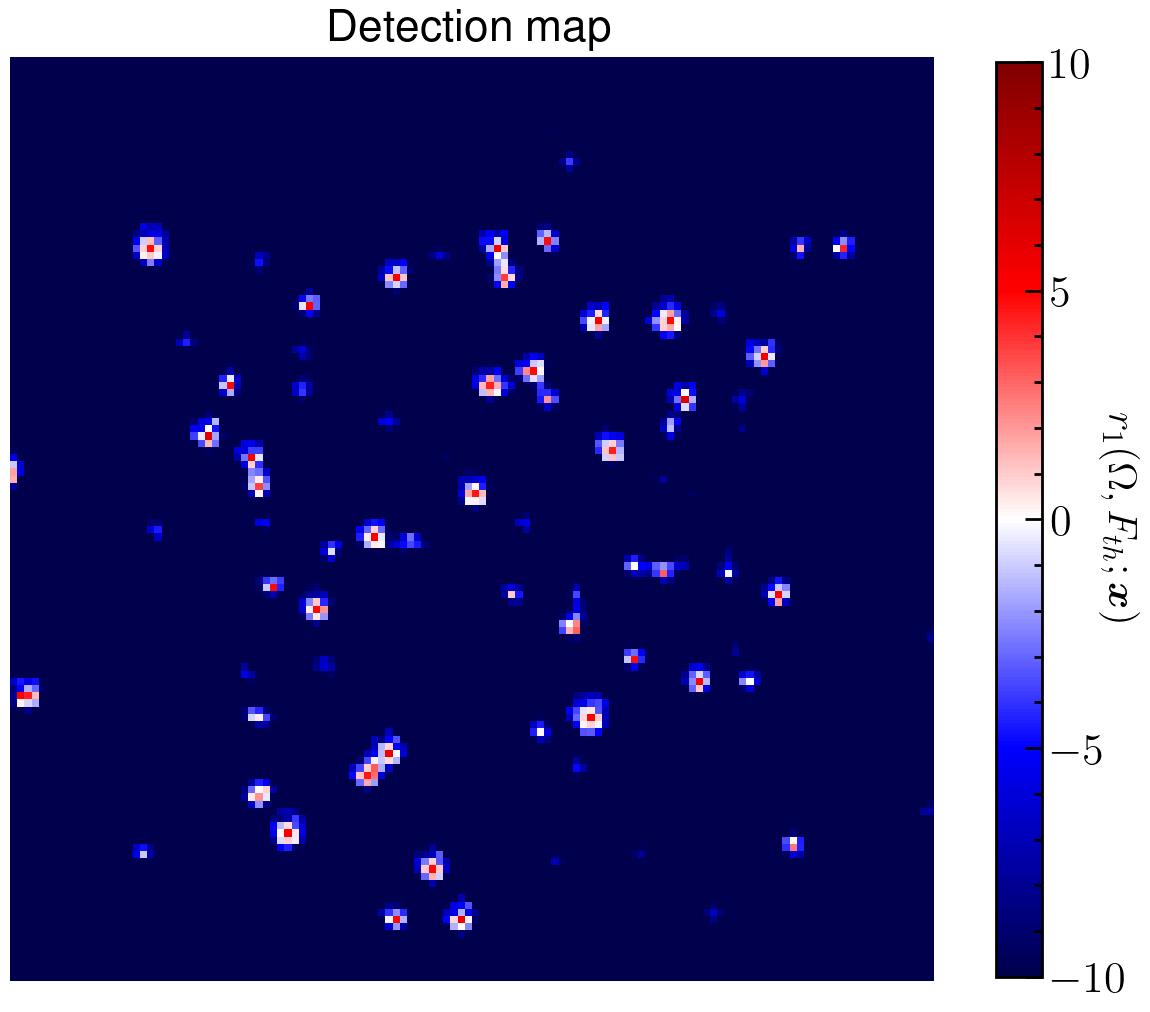

In [17]:
fig, ax = plt.subplots(1, 1, dpi=200)
im = plt.imshow(maps[..., 7] , cmap = 'seismic', vmin = -10, vmax = 10)
plt.axis('off')
# subfigs[1].suptitle(r'Exclusion map for $F_\mathrm{th}$', size=15)
cbar = plt.colorbar(im, ax=ax, ticks=[-10, -5, 0, 5, 10], shrink=0.99)
cbar.set_label(label=r'$r_1( \Omega, F_{th}; \boldsymbol{x})$', rotation=270, size=15)
plt.title(r'Detection map')

In [18]:
# ax = subfigs[1].subplots(1, 1)
im = axs[1].imshow(maps[..., 7] , cmap = 'seismic', vmin = -10, vmax = 10)
axs[1].axis('off')
# subfigs[1].suptitle(r'Exclusion map for $F_\mathrm{th}$', size=15)
cbar = subfigs[0].colorbar(im, ax=axs[1], shrink=0.93)
cbar.set_label(label=r'$r_1( \Omega, F_{th}; \mathbf{x})$', rotation=270, size=15)
axs[1].set_title(r'Detection map')

Text(0.5, 1.0, 'Detection map')

In [159]:
# axs = subfigs[1].subplots(3, 4)
# for i, a in enumerate(axs.flatten()):
#     im = a.imshow(maps[..., i] , cmap = cmap, vmin = -10, vmax = 10)
#     a.axis('off')
# #     plt.colorbar(im, ax=ax)

### Sensitivity function

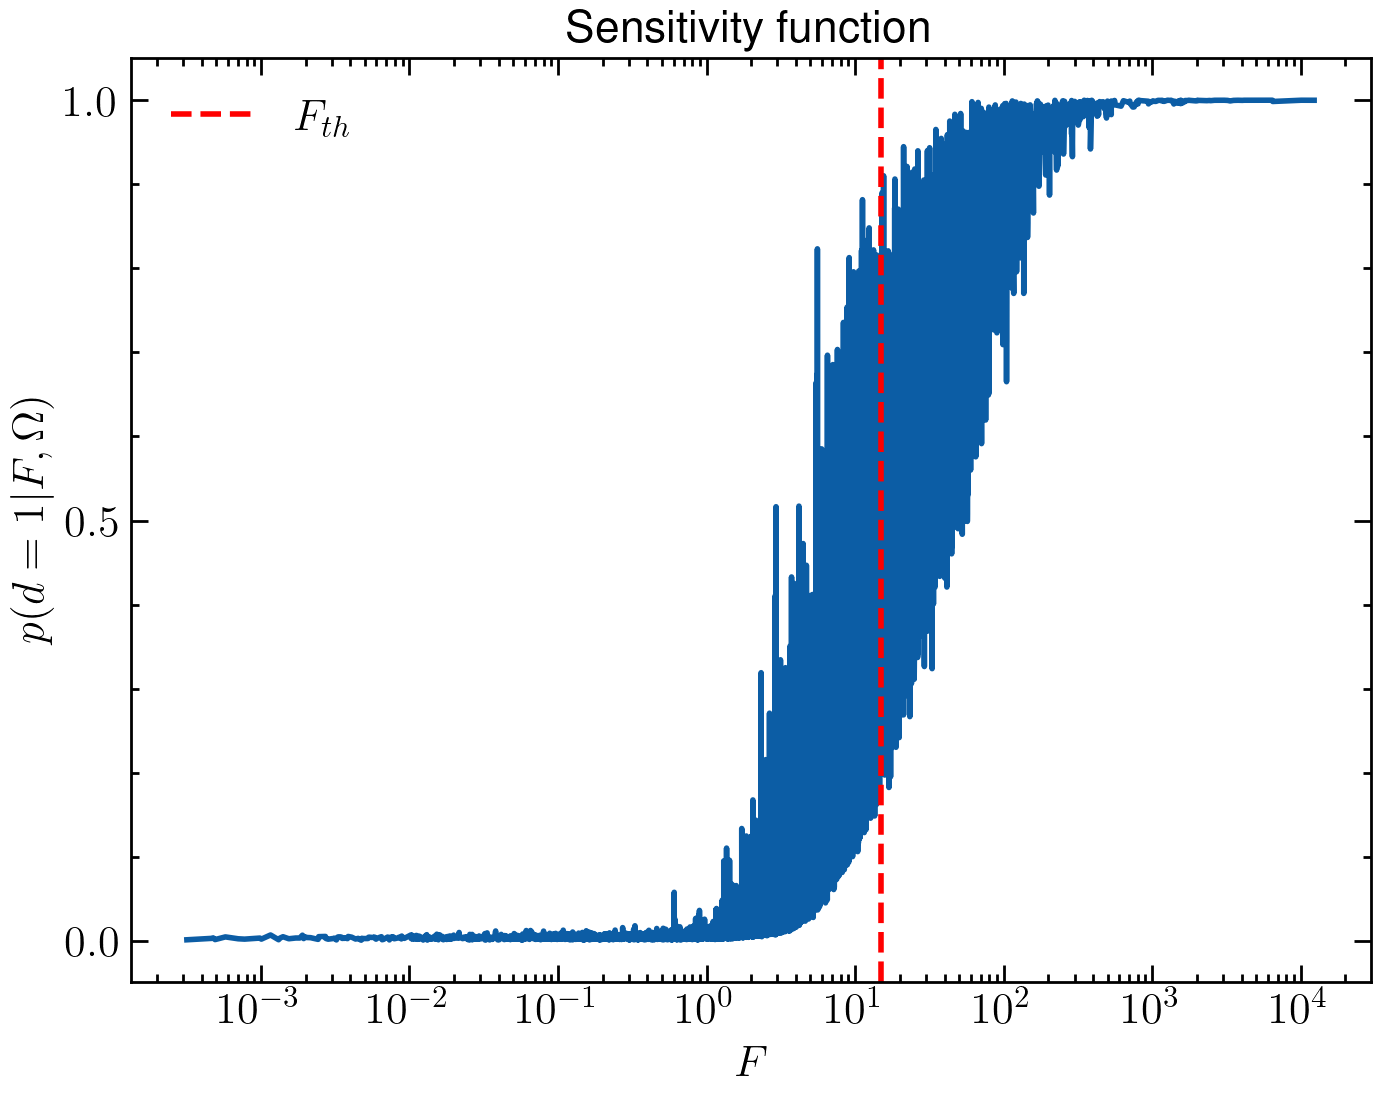

In [23]:
plt.figure(dpi=200)
plt.semilogx(
    10**log10f[log10f.argsort()], 
    torch.sigmoid(((prior_d1*logr2_1.exp())/(prior_d0*logr2_0.exp())).log()) [log10f.argsort()]
);
plt.xlabel(r'$F$')
plt.yticks([0., 0.5, 1.])
plt.ylabel(r'$p(d=1|F, \Omega)$')
plt.axvline(15, c='r', ls='--', label=r"$F_{th}$")
# axs[2].axhline(0.5, c='r', ls='--')
plt.title('Sensitivity function')
plt.legend();

In [160]:
axs[2].semilogx(
    10**log10f[log10f.argsort()], 
    torch.sigmoid(((prior_d1*logr2_1.exp())/(prior_d0*logr2_0.exp())).log()) [log10f.argsort()]
);
axs[2].set_xlabel(r'$F$')
axs[2].set_yticks([0., 0.5, 1.])
axs[2].set_ylabel(r'$p(d=1|F, \Omega)$')
axs[2].axvline(17.8, c='r', ls='--', label=r"$F_{th}$")
# axs[2].axhline(0.5, c='r', ls='--')
axs[2].set_title('Sensitivity function')
axs[2].legend();

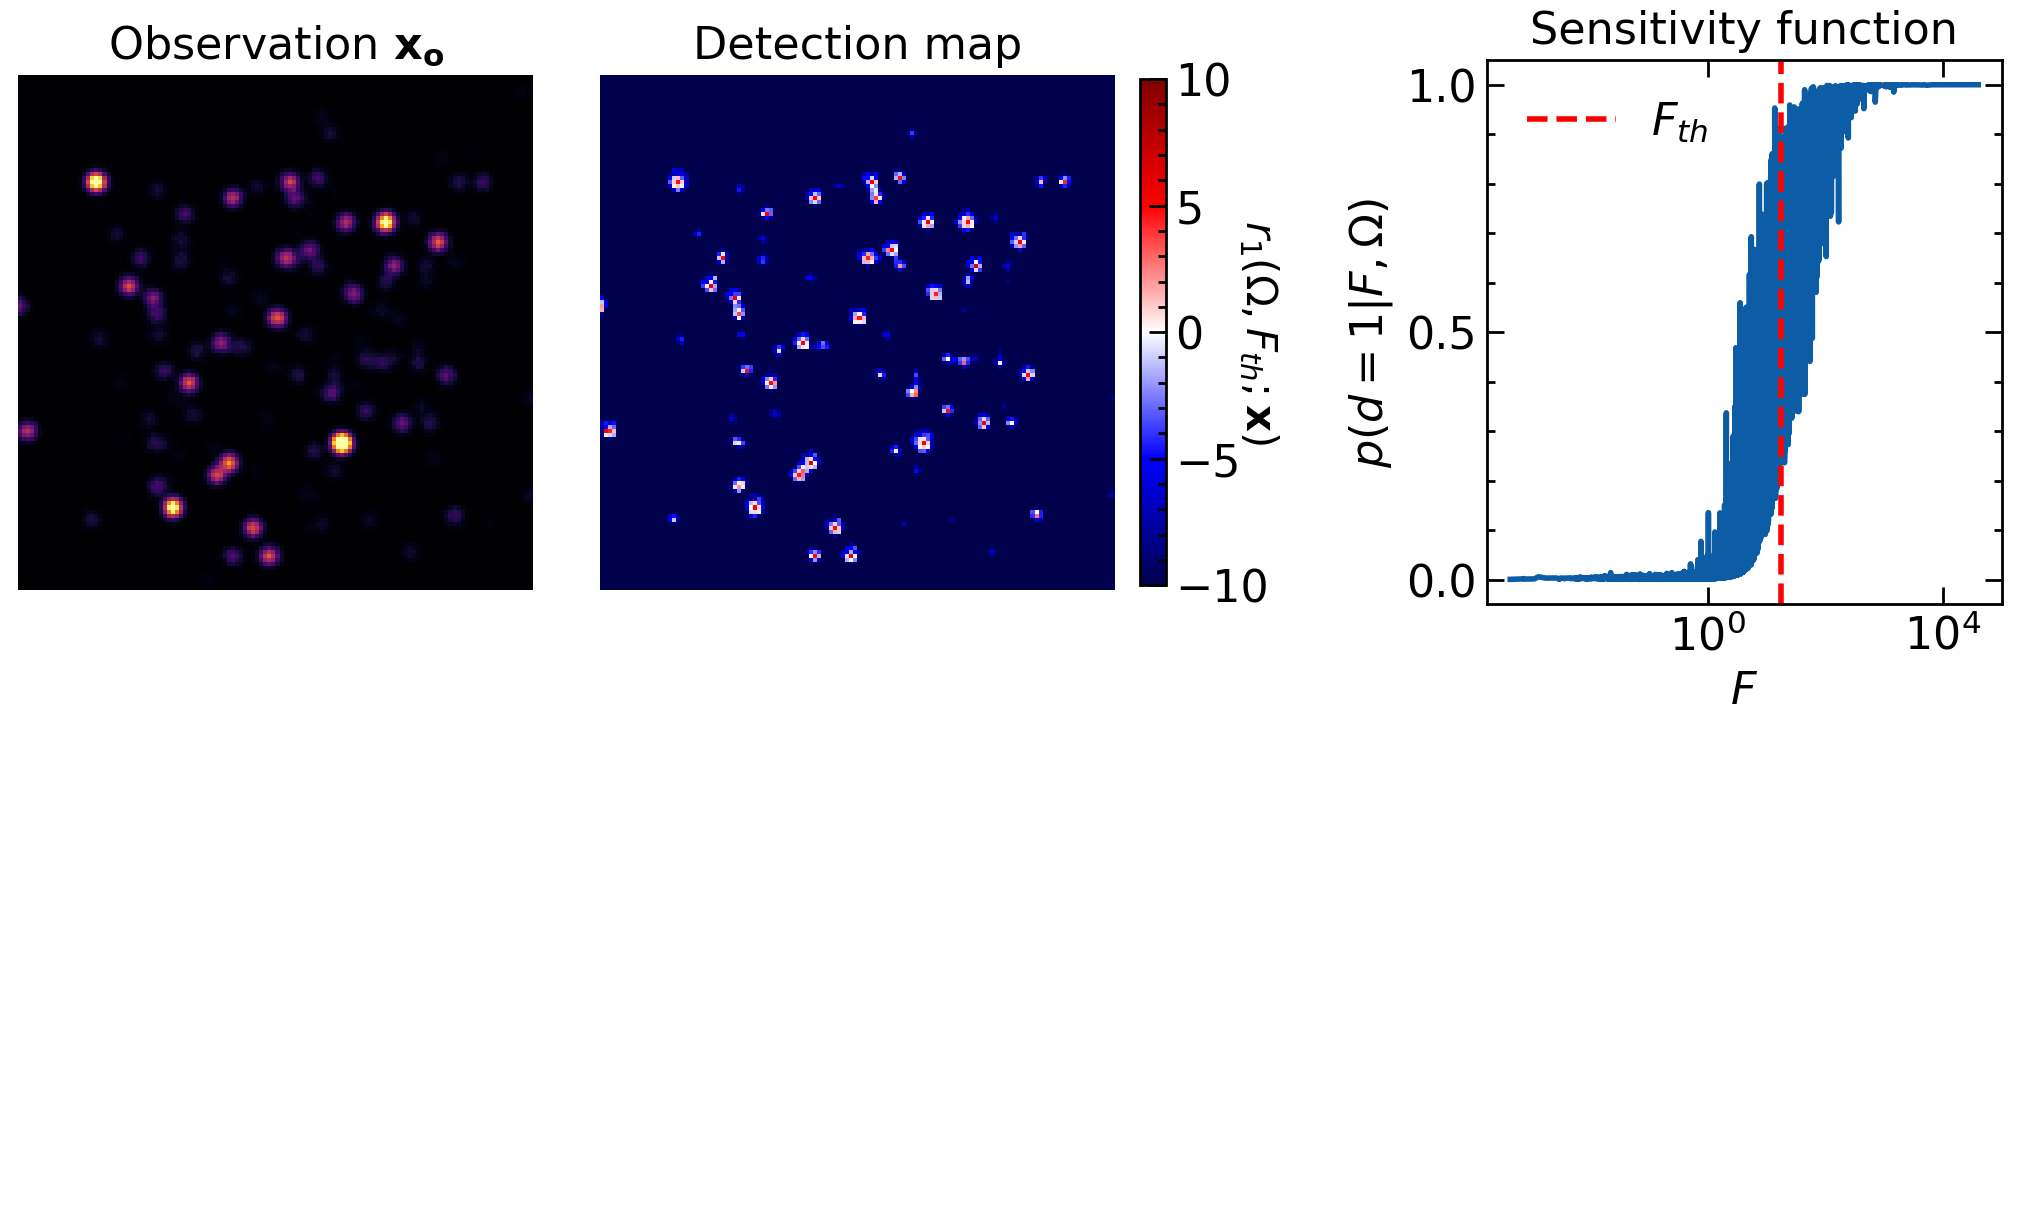

In [161]:
fig

### Data

In [28]:
# Data
n = 7

simulator0 = sims.ToyFermi(npix = 128)
sim0 = [simulator0.sample()['data'] for i in range(n)]

psc_det = torch.tensor(np.load('neurips_ps_det.npy'))
bounds = sims.ToyFermiBound(detected = psc_det, threshold = 10)
simulator1 = sims.ToyFermiSensitivity(bounds=bounds, npix = 128, sensitivity_function=network_d)
sim1 = [simulator1.sample()['data'] for i in range(n)]

Text(0, 0.5, 'Targeted data')

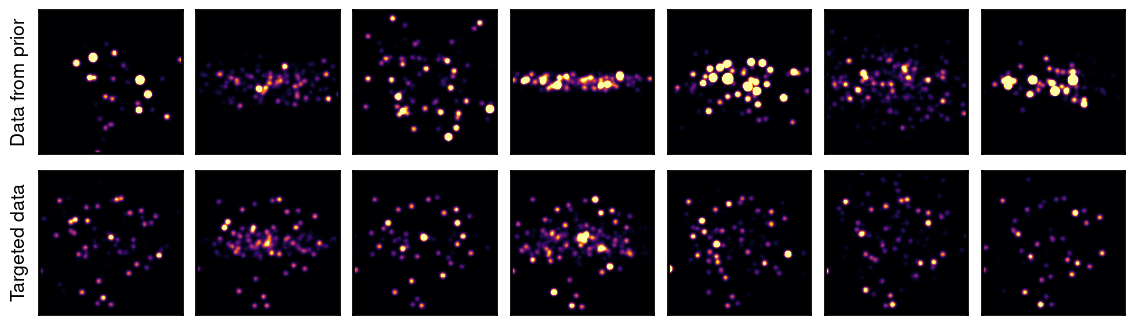

In [29]:
# fig = plt.figure(constrained_layout=True, figsize=(15, 4), dpi=200)
# subfigs = fig.subfigures(1, 2, wspace=0.1, width_ratios=[1, 3])

fig, axs = plt.subplots(2, n,  sharex=True, sharey=True, figsize=(7, 2), dpi=200,  gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

# axs = subfigs[1].subplots(2, n, gridspec_kw={'wspace': 0, 'hspace': 0})

for i in range(n):
    axs[0, i].imshow(sim0[i], cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1, i].imshow(sim1[i], cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0, i].set_xticks([],[])
    axs[0, i].set_yticks([],[])
    axs[1, i].set_xticks([],[])
    axs[1, i].set_yticks([],[])
    
axs[0, 0].set_ylabel("Data from prior", size =7)
axs[1, 0].set_ylabel("Targeted data", size =7)

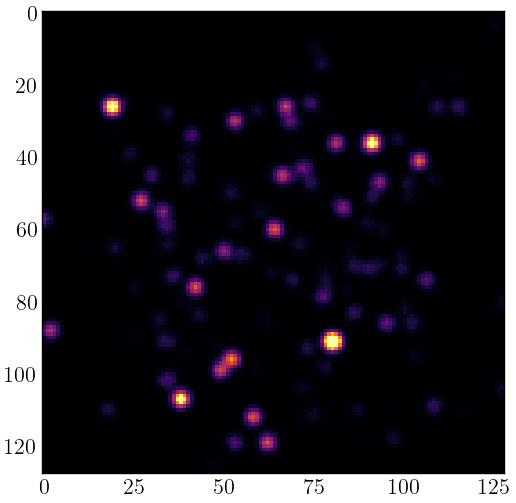

In [30]:
plt.imshow(s0['data'], cmap=cmap, vmin=vmin, vmax=vmax)